In [1]:
import pandas as pd
import numpy as np
import sklearn
from xgboost import XGBClassifier
import xgboost
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import pickle
from sklearn.utils import shuffle
import json
import os
from xgboost import XGBClassifier
from matplotlib import pyplot

In [2]:
#Don't use datetime, Don't use categorical features, xgboost doesn't do those, first one hot encode
featuresToUse = ['visitor_hist_starrating', 'visitor_hist_adr_usd',
       'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'comp1_rate', 'comp1_inv',
                 'mean_prop_starrating',
       'mean_prop_review_score', 'mean_prop_brand_bool',
       'mean_prop_location_score1', 'mean_prop_location_score2',
       'mean_prop_log_historical_price','cluster__0','cluster__1','cluster__2','cluster__3','cluster__4','cluster__5','diff_distance_orig']
labelToPredict = 'click_bool'
neededVars = ['srch_id', 'booking_bool']
nameOfModel = "janinemodelClick"

In [3]:
df = pd.read_csv('C:/Users/janine van wonderen/Desktop/dmt2/80PercentTrainWithMean.csv', delimiter=",",usecols=featuresToUse+[labelToPredict]+neededVars)

In [4]:
df = df.sort_values(by = ['srch_id'])

In [5]:
x = df['srch_id'].value_counts().sort_index().values
x

array([22, 24,  3, ..., 15, 23,  6], dtype=int64)

In [6]:
dfNeeded= df[neededVars+[labelToPredict]]
Y = df[labelToPredict]
df.drop(neededVars+[labelToPredict],axis=1,inplace=True)

Lets train it on clicking

In [7]:
# construct xgboost.DMatrix from numpy array, treat -999.0 as missing value
#xgmat = xgboost.DMatrix( df, label=y_train)
xgmat = xgboost.DMatrix(df, label=Y)
xgmat.set_group(x)
# setup parameters for xgboost
param = {}
# use logistic regression loss, use raw prediction before logistic transformation
# since we only need the rank
param['objective'] = 'rank:pairwise'#'reg:logistic'
# scale weight of positive examples
param['scale_pos_weight'] = sum(Y==0)/sum(Y==1)
param['eta'] = 0.1
param['max_depth'] = 4
param['eval_metric'] = 'auc'
param['silent'] = 0
param['colsample_bytree'] = 0.8


# you can directly throw param in, though we want to watch multiple metrics here
plst = list(param.items())

watchlist = [ (xgmat,'train') ]

num_round = 120
print ('loading data end, start to boost trees')
bst = xgboost.train( plst, xgmat, num_round, watchlist ,early_stopping_rounds=5);
# save out model
bst.save_model(nameOfModel+".model")

print ('finish training')


C:\Users\janine van wonderen\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\janine van wonderen\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


loading data end, start to boost trees


XGBoostError: b'[14:05:35] C:\\Users\\Administrator\\Desktop\\xgboost\\src\\metric\\rank_metric.cc:144: Check failed: !auc_error AUC: the dataset only contains pos or neg samples'

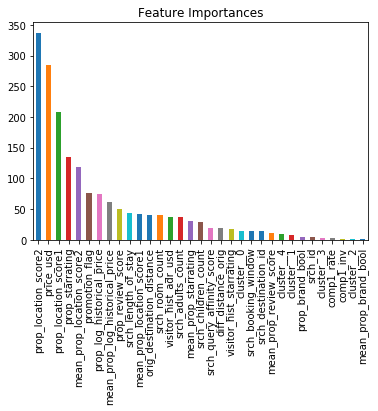

In [21]:
feat_imp = pd.Series(bst.get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')


In [22]:
df = pd.read_csv('C:/Users/janine van wonderen/Desktop/dmt2/20PercentTestWithMean.csv', delimiter=",",usecols=featuresToUse+[labelToPredict]+neededVars)
dfNeeded= df[neededVars+[labelToPredict]]
Y = df[labelToPredict]
df.drop(neededVars+[labelToPredict],axis=1,inplace=True)

In [23]:
xgmat_test = xgboost.DMatrix( df, label=Y)
y_pred = bst.predict(xgmat_test)

C:\Users\janine van wonderen\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\janine van wonderen\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [24]:
predictions = [round(value) for value in y_pred]
df = pd.concat([df,dfNeeded],axis=1)
df['y_pred'] = y_pred

In [25]:
def getScore(df):
    df['rank_srch_id'] = df.groupby('srch_id').cumcount().add(1)
    df['gain'] = 5*df['booking_bool']
    df['gain'] = np.where(df['gain'] == 0, df['click_bool'], df['gain'])

    df['g/rank'] = df['gain']/df['rank_srch_id']
    gi_sum = df['g/rank'].sum()
    
    df['gain_sorted'] = list(df[['srch_id', 'booking_bool', 'click_bool', 'gain']].sort_values(by = ['srch_id','booking_bool','click_bool'], ascending = [True, False, False])['gain'])
    df['g/rank_sorted'] = df['gain_sorted']/df['rank_srch_id']
    gi_sorted_sum = df['g/rank_sorted'].sum() 
    score = gi_sum/gi_sorted_sum
    return score, gi_sum, gi_sorted_sum

In [26]:
score, gi_sum, gi_sorted_sum = getScore(df.sort_values(by=['srch_id', 'y_pred'], ascending = [True, False]).reset_index(drop=True))
print(score)

# evaluate predictions
accuracy = accuracy_score(df['click_bool'], predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))



0.6558520849419839
Accuracy: 61.91%


In [27]:
f=open("scores.txt", "a+")
f.write("Score: "+str(score)+"\n")
f.write("Label to predict: "+str(labelToPredict)+"\n")
f.write("Features used:\n")
f.write(str(list(featuresToUse)) +"\n")
f.write("Parameters xgboost:\n")
f.write(str(json.dumps(param))+"\n")
f.write("Number of rounds:\n"+str(num_round)+"\n")
f.close()

In [28]:
os.rename(nameOfModel+".model",nameOfModel+str(int(score*100))+".model")
newNameOfModel = nameOfModel+str(int(score*100))

Lets combine the models

In [29]:
clickingModel = xgboost.Booster()
clickingModel.load_model('models/7mayClicking.model')
bookingModel = xgboost.Booster()
bookingModel.load_model(newNameOfModel+".model")

XGBoostError: b'[13:02:14] C:\\Users\\Administrator\\Desktop\\xgboost\\dmlc-core\\src\\io\\local_filesys.cc:209: Check failed: allow_null  LocalFileSystem::Open "models/7mayClicking.model": No such file or directory'

In [68]:
df = pd.read_csv('C:/Users/janine van wonderen/Desktop/dmt2/20PercentTestWithMean.csv', delimiter=",",usecols=featuresToUse+[labelToPredict]+neededVars)
dfNeeded= df[neededVars+[labelToPredict]]
df.drop(neededVars+[labelToPredict],axis=1,inplace=True)

In [69]:
xgmat_test = xgboost.DMatrix( df)
y_pred_clicking = clickingModel.predict(xgmat_test)
y_pred_booking = bookingModel.predict(xgmat_test)

In [70]:
df = pd.concat([df,dfNeeded],axis=1)
df['y_pred_clicking'] = y_pred_clicking
df['y_pred_booking'] = y_pred_booking
df['combined'] = y_pred_booking+y_pred_clicking

In [71]:
score_apart, gi_sum, gi_sorted_sum = getScore(df.sort_values(by=['srch_id', 'y_pred_booking', 'y_pred_clicking'], ascending = [True, False,False]).reset_index(drop=True))
score_combined, gi_sum, gi_sorted_sum = getScore(df.sort_values(by=['srch_id', 'combined'], ascending = [True, False]).reset_index(drop=True))
print("Sort first on booking and then on clicking: "+str(score_apart))
print("Combine then sort: "+str(score_combined))

Sort first on booking and then on clicking: 0.6619786337448552
Combine then sort: 0.6619786337448552


Evaluation

In [3]:
dfTest = pd.read_csv("C:/Users/janine van wonderen/Desktop/dmt2/testWithMean.csv")

In [4]:
clickingModel = xgboost.Booster({'nthread': -1})  # init model
clickingModel.load_model("models/8mayClicking50066.model")
#bookingModel = xgboost.Booster({'nthread': -1})  # init model
#bookingModel.load_model("models/7mayBooking75.model")

In [5]:
xgmat_test_submission = xgboost.DMatrix(dfTest[featuresToUse])
y_pred_clicking = clickingModel.predict(xgmat_test_submission)
#y_pred_booking = bookingModel.predict(xgmat_test_submission)
dfTest['predictedPos'] = y_pred_clicking#+y_pred_booking
dfTest = dfTest.sort_values(['srch_id','predictedPos'],ascending=[True, False])
dfSubmission = dfTest[['srch_id','prop_id']]
dfSubmission.to_csv("submissionTest8may.csv",index=False)